In [1]:
import pandas as pd
import numpy as np
import gc
import seaborn as sns
import dask as dd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot
from scipy.stats.stats import pearsonr 

In [2]:
train = pd.read_parquet('../input/ubiquant-parquet/train.parquet')
#train_dask = dd.read_parquet('../input/ubiquant-parquet/train.parquet')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: float64(301), int64(2), object(1)
memory usage: 7.1+ GB


In [4]:
train.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


## Check distribution of time sampling per investment ID

In [5]:
# pivot the investment IDs and target for counts

table = pd.pivot_table(train, values='target', index = "investment_id", aggfunc = {"target": "count"})
table.head()

,target
investment_id,
0,461
1,1108
2,1003
3,1076
4,316


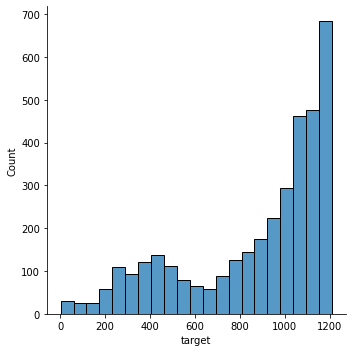

In [6]:
# check the distribution of time samples
sns.displot(table.target)

In [7]:
table = pd.pivot_table(train, values='target', index = "investment_id", columns = ["time_id"])
table.head()

time_id,0,1,2,3,4,5,6,7,8,9,...,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219
investment_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.472723,-0.236285,-2.621014,0.129619,1.138975,0.579622,0.064896,2.204664,1.037581,-2.631323
1,-0.300875,-0.917045,-0.480234,-0.323562,2.494479,0.299347,-1.381707,0.913922,-0.661152,-0.867373,...,0.072360,-0.071978,0.135815,0.226359,-0.167262,0.078338,-0.290113,-0.097136,-0.080295,0.656833
2,-0.231040,-0.472108,-0.661659,-0.055215,0.341267,-1.179242,-0.644588,-0.581904,-0.659482,-0.080913,...,-0.002608,-0.254329,-0.411340,0.169154,0.187624,-0.361899,-0.688692,0.007041,-0.082326,0.032135
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.269154,1.305137,0.280275,2.222628,1.267150,1.624498,-0.070665,1.532567,0.384600,0.401314
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.737825,0.373363,-0.896088,0.563158,0.411833,0.968079,-0.514005,-0.207239,0.318535,-0.060477


<AxesSubplot:xlabel='time_id', ylabel='investment_id'>

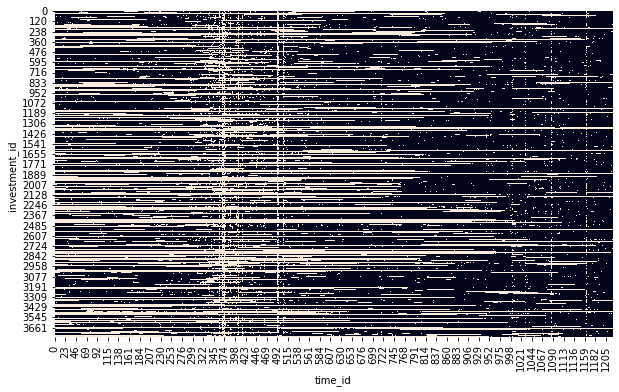

In [8]:
# check the null values

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(table.isnull(), cbar=False)

In [9]:
table = table.reset_index()

In [10]:
y = table.iloc[:,1:].values
y

array([[        nan,         nan,         nan, ...,  2.2046645 ,
         1.0375807 , -2.6313226 ],
       [-0.30087492, -0.9170453 , -0.48023373, ..., -0.09713581,
        -0.08029506,  0.65683335],
       [-0.23104009, -0.47210816, -0.6616591 , ...,  0.00704083,
        -0.08232557,  0.03213458],
       ...,
       [-0.28469563, -0.89482486, -0.3237996 , ..., -0.47772774,
        -0.11986875, -0.559415  ],
       [ 0.2020026 , -0.28661188,  0.30091488, ..., -0.42294976,
         0.51373863,  0.00959892],
       [        nan,         nan,         nan, ...,  1.4928325 ,
        -0.3862939 ,  1.2121116 ]])

## Clustering using Kmeans

In [11]:
# interpolate target missing values using KNN

imputer = KNNImputer(n_neighbors=2, weights="uniform")
y = imputer.fit_transform(y)

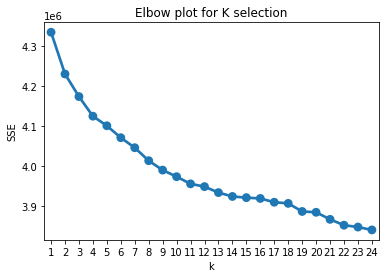

In [12]:
# Check optimum number of clusters using elbow method

sse = {}
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k, random_state=1)
    scaler = StandardScaler()
    y_std = scaler.fit_transform(y)
    kmeans.fit(y_std)
    sse[k] = kmeans.inertia_
    
plt.title('Elbow plot for K selection')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()),
                 y=list(sse.values()))
plt.show()

In [13]:
# define the model
model = KMeans(n_clusters=10)
# fit the model
kmeans = KMeans(n_clusters=k, random_state=1)
scaler = StandardScaler()
y_std = scaler.fit_transform(y)
model.fit(y_std)
# assign a cluster to each example
yhat = model.predict(y_std)
# retrieve unique clusters
clusters = unique(yhat)

In [14]:
#create clustered dataframe

clustered_df = pd.DataFrame({"id": table.investment_id.values, "cluster": yhat, "target": y.tolist()})
clustered_df.to_parquet("clustered.parquet")
clustered_df.head()

,id,cluster,target
0,0,8,"[-0.5021969000000001, 0.17583667000000003, 0.1..."
1,1,2,"[-0.30087492, -0.9170453, -0.48023373, -0.3235..."
2,2,1,"[-0.23104009, -0.47210816, -0.6616591, -0.0552..."
3,3,5,"[0.7823927449999999, 0.47056756000000005, 0.58..."
4,4,2,"[-0.69876465, -0.48367217649999994, 0.05268197..."


## check correlation of targets in clusters

In [15]:
# filter a cluster
cluster = 5
cluster_filt = clustered_df[clustered_df["cluster"] == cluster].copy()

#sample two random investment IDs
cluster_filt = cluster_filt.sample(n=2, axis = 0, replace = True)
cluster_filt.head()

,id,cluster,target
1051,1117,5,"[2.3701584, 0.15053865, -1.9941521, 0.84764415..."
1595,1685,5,"[6.0124512e-05, 0.185150087, -0.81999643500000..."


In [16]:
# calculate correlation of the two targets

signal_1 = np.asarray(cluster_filt.target.iloc[0])
signal_2 =  np.asarray(cluster_filt.target.iloc[1])
corr = pearsonr(signal_1,signal_2)
print(corr)


(0.13204413765439774, 4.016703269830822e-06)


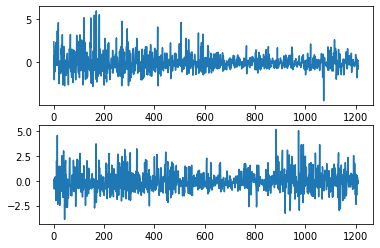

In [17]:
fig, ax = plt.subplots(2,1)
for i in range(0,2):
    time = [*range(0,len(cluster_filt.iloc[i,2]))]
    sns.lineplot(x=time, y = cluster_filt.iloc[i,2], ax = ax[i])

### check distribution of correlation coefficients in each cluster

In [18]:
def get_correlations(cluster):
    
    cluster_filt = clustered_df[clustered_df["cluster"] == cluster].copy()

    #sample two random investment IDs
    cluster_filt = cluster_filt.sample(n=2, axis = 0)
    signal_1 = np.asarray(cluster_filt.target.iloc[0])
    signal_2 =  np.asarray(cluster_filt.target.iloc[1])
    corr = pearsonr(signal_1,signal_2)
    
    return corr[0]
    

In [19]:
def plot_cluster_corr(cluster,repeat_times):
    
    correlations=[]
    for i in range(0,repeat_times):     
        corr = get_correlations(cluster)
        correlations.append(corr)
    #fig, ax = plt.subplots(figsize=(5,5))
    ax = sns.displot(x=correlations)
    plt.title("cluster_"+ str(cluster))
    return ax

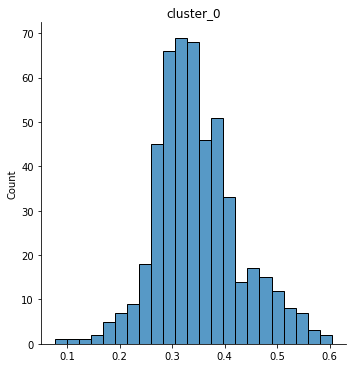

In [20]:
ax = plot_cluster_corr(0,500)

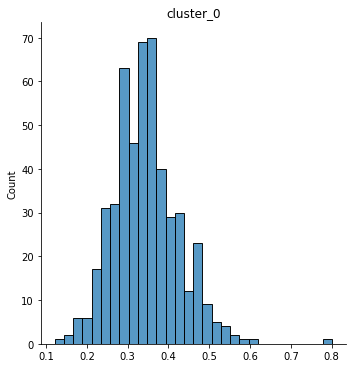

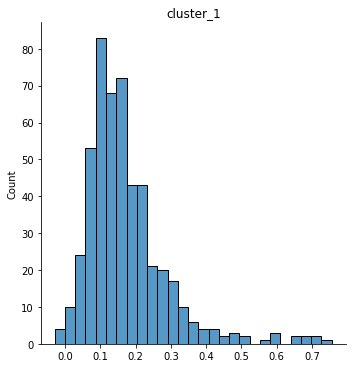

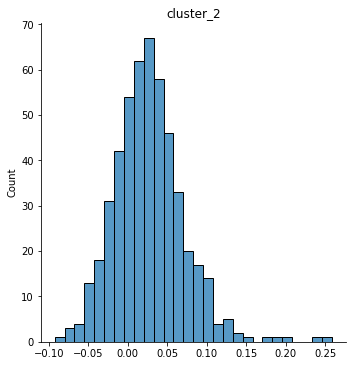

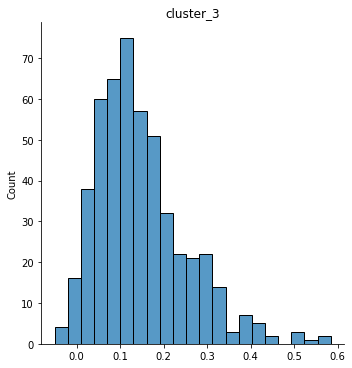

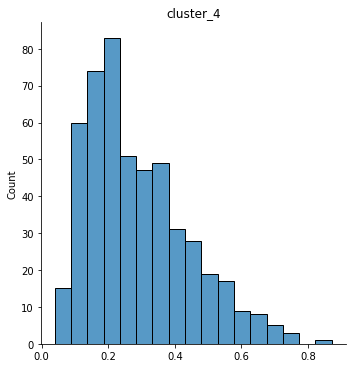

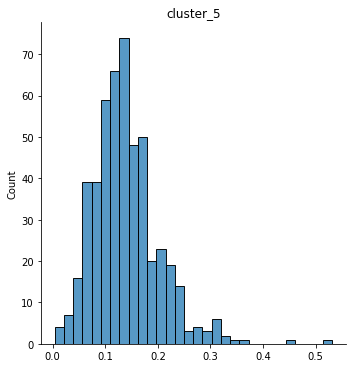

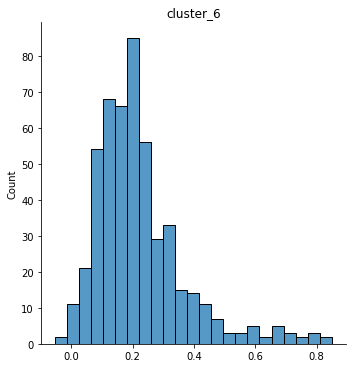

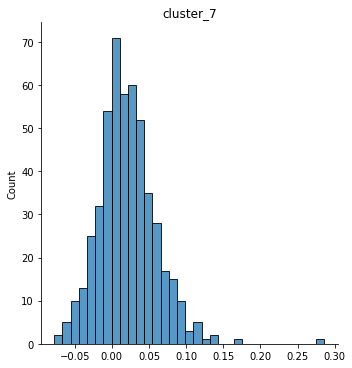

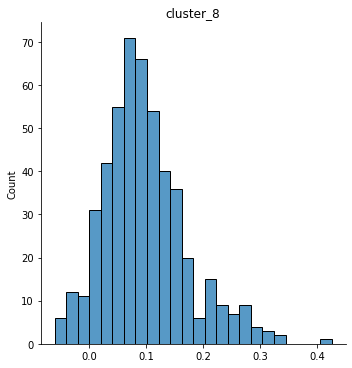

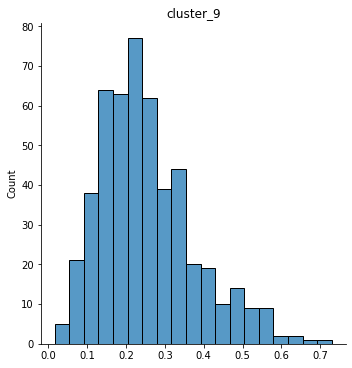

In [21]:
cluster_list = list(clustered_df.cluster.unique())
cluster_list.sort()
#fig, ax = plt.subplots(5,2, figsize = (10,10))
for i,cluster in enumerate(cluster_list):
    plot_cluster_corr(cluster,500)
    